# Cats-vs.-Dogs Image Classification. Classic ML Models

This section addresses an image classification problem, utilizing classic machine learning models to distinguish between images of cats and dogs. The analysis leverages a preprocessed dataset which uses the first 2,000 images (forming the dataset rows), resized to 150x150 pixels. With three color channels, this results in 67,500 features per image. The target variable is binary (0: cat, 1: dog). Key challenges include managing the high dimensionality of the feature set relative to the number of samples and optimizing hyperparameters to identify the best-performing models.

- Sachin, Shaunthesheep (2020). Dataset: Cats-vs-Dogs : image dataset for binary classification. URL: [https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset)

***

## Setup: Importing Packages and Defining Utility Functions
The following cells import the required packages and defines functions to enhance code readability and prevent duplication.

In [ ]:
!pip install pca --quiet

In [ ]:
# General imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import zipfile
import io
import seaborn as sns
from tqdm import tqdm

# Image processing and decompositions functions
from pca import pca
from skimage import color, exposure
from skimage.feature import hog

# Classification models functions and measures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
# Global variables
BASE_URL = "https://raw.githubusercontent.com/alexARC26/portfolio-classification-neural-networks/main/data/"
DATASET_URL_1 = BASE_URL + "CatsDogsDataset_1.zip"
DATASET_URL_2 = BASE_URL + "CatsDogsDataset_2.zip"
CSV_FILENAME = "CatsDogsDataset.csv"
IMAGE_SIZE = 150
CLASS_NAMES = ["Cat", "Dog"]

# Data input functions
def read_csv_from_github_zip(zip_url, csv_filename):
    """
    Download a ZIP file from a GitHub URL, extract a specified CSV, and return it as a DataFrame.

    Parameters:
        zip_url (str): URL of the ZIP file hosted on GitHub.
        csv_filename (str): Name of the CSV file to extract from the ZIP.

    Returns:
        pd.DataFrame: DataFrame containing the CSV data, or None if an error occurs.
    """
    try:
        # Download the ZIP file from the provided URL. Raise an exception for HTTP errors (e.g., 404)
        response = requests.get(zip_url)
        response.raise_for_status()

        # Create a file-like object from the downloaded ZIP content
        zip_content = io.BytesIO(response.content)

        # Open the ZIP file for reading
        with zipfile.ZipFile(zip_content, 'r') as zf:
            # Check if the specified CSV exists in the ZIP
            if csv_filename not in zf.namelist():
                raise ValueError(f"CSV file '{csv_filename}' not found in ZIP")

            # Extract and read the CSV file directly into a DataFrame
            with zf.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file)

        # Return the resulting DataFrame
        return df

    except requests.exceptions.RequestException as e:
        # Handle network or HTTP errors during download
        print(f"Error downloading ZIP from {zip_url}: {e}")
        return None

    except zipfile.BadZipFile:
        # Handle cases where the downloaded file is not a valid ZIP
        print(f"Error: The file at {zip_url} is not a valid ZIP")
        return None

    except Exception as e:
        # Catch any other errors (e.g., CSV parsing issues, file corruption)
        print(f"Error processing ZIP or CSV: {e}")
        return None

# Plot image functions
def plot_single_image(X_values, subtitle_text="", colorMap=None, yText=None):
    """
    Plot a single image with optional subtitle and text label.

    Parameters:
    - X_values: Array-like, image data (1D or 3D format).
    - subtitle_text: String, title for the image (default: "").
    - colorMap: String, matplotlib colormap for the image (default: None).
    - yText: String, text to display on the y-axis (default: None).
    """
    # Check if X_values is in 1D format and reshape to 3D if necessary
    dim_X = len(X_values.shape)
    if dim_X == 1:
        n_color_channels = int(X_values.shape[0] / (IMAGE_SIZE * IMAGE_SIZE))

        # Reshape 1D array to 3D (height, width, channels) and normalize pixel values
        X_values = np.array(X_values).reshape(IMAGE_SIZE, IMAGE_SIZE, n_color_channels)
        X_values = X_values / 255

        # Set colormap to grayscale for single-channel images
        colorMap = "gray"

    # Display the image, add subtitle and hide axes for tidier visualization
    plt.imshow(X_values, interpolation='nearest', cmap=colorMap)
    plt.title(subtitle_text, fontsize=14, loc="left")
    plt.axis('off')

    # Add optional text label on the y-axis
    if yText is not None:
        plt.text(x=-0.2, y=0.5, s=yText, ha='center', va='center',
                 transform=plt.gca().transAxes, fontsize=14)

def plot_gallery(X_values, y_values, y_labels=None, selection=None, main_title="Image Gallery", title_offset=[0.075, 0.97]):
    """
    Plot a gallery of images with their class labels and optional predicted labels.

    Parameters:
    - X_values: Array-like or DataFrame, image data.
    - y_values: Array-like, true class labels for the images.
    - y_labels: Array-like, predicted class labels (default: None).
    - selection: List, indices of images to display (default: None, uses all images).
    - main_title: String, title for the gallery (default: "Image Gallery").
    - title_offset: List, [x, y] coordinates for the main title (default: [0.075, 0.97]).
    """
    # Use all images if no selection is provided
    if selection is None:
        selection = list(range(len(y_values)))

    # Initialize figure with specified size. Also, set # of images to display in n_rows
    fig = plt.figure(figsize=(17, 10))
    n_in_gallery = 15
    n_rows = 3

    # Select a random subset of images from the selection
    n_in_selection = len(selection)
    random_subset = random.sample(sorted(selection), min(n_in_gallery, n_in_selection))

    # Plot each image in the gallery
    for i in range(min(n_in_gallery, n_in_selection)):
        plt.subplot(n_rows, int(np.ceil(n_in_gallery / n_rows)), i + 1)
        random_index = random_subset[i]

        # Extract single image data (handle DataFrame or array input)
        if isinstance(X_values, pd.DataFrame):
            single_row = X_values.iloc[random_index, ]
        else:
            single_row = X_values[random_index, ]

        # Create subtitle with true class name and optional predicted label
        subtitle_text = CLASS_NAMES[y_values[random_index]]
        if y_labels is not None:
            subtitle_text += ". Pred: " + CLASS_NAMES[y_labels[random_index]]

        plot_single_image(X_values=single_row, subtitle_text=subtitle_text)

    # Adjust layout and add main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(main_title, x=title_offset[0], y=title_offset[1], fontsize=16)
    plt.show()

def plot_gallery_representations(rgb_values, gray_values, pca_inv_scores_100, pca_inv_scores_all,
                                hog_inv_scores, y_values, selection=None,
                                main_title="Image gallery: Representations", title_offset=[0.125, 0.97]):
    """
    Plot a gallery comparing different image representations (RGB, grayscale, PCA, HOG).

    Parameters:
    - rgb_values: Array-like, original RGB image data.
    - gray_values: Array-like or DataFrame, grayscale image data.
    - pca_inv_scores_100: Array-like, PCA-reconstructed images (100 components).
    - pca_inv_scores_all: Array-like, PCA-reconstructed images (all components or 95% variance).
    - hog_inv_scores: Array-like, HOG feature visualizations.
    - y_values: Array-like, true class labels for the images.
    - selection: List, indices of images to display (default: None, uses all images).
    - main_title: String, title for the gallery (default: "Image gallery: Representations").
    - title_offset: List, [x, y] coordinates for the main title (default: [0.125, 0.97]).
    """
    # Use all images if no selection is provided
    if selection is None:
        selection = list(range(len(y_values)))

    # Initialize figure with specified size
    fig = plt.figure(figsize=(17, 10))
    n_in_gallery = 3  # Number of images to display

    # Select a random subset of images from the selection
    n_in_selection = len(selection)
    random_subset = random.sample(sorted(selection), min(n_in_gallery, n_in_selection))

    # Collect image representations and class labels
    image_sets = [arr[random_subset] for arr in
      [rgb_values,gray_values,pca_inv_scores_100,pca_inv_scores_all, hog_inv_scores]]
    class_labels = [CLASS_NAMES[y_values[i]] for i in random_subset]
    image_names = ["Original image", "Gray", "PCA-100", "PCA-95%", "HOG"]

    # Plot each image representation in a grid
    for row in range(min(n_in_gallery, n_in_selection)):
        for img in range(len(image_names)):
            plt.subplot(min(n_in_gallery, n_in_selection), 5, img + (5 * row) + 1)
            # Add subtitle for the first row and y-axis text for the first column
            if row == 0:
                if img == 0:
                    plot_single_image(X_values=image_sets[img][row], subtitle_text=image_names[img],
                                     yText=class_labels[row])
                else:
                    plot_single_image(X_values=image_sets[img][row], subtitle_text=image_names[img])
            else:
                if img == 0:
                    plot_single_image(X_values=image_sets[img][row], yText=class_labels[row])
                else:
                    plot_single_image(X_values=image_sets[img][row])

    # Adjust layout and add main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(main_title, x=title_offset[0], y=title_offset[1], fontsize=16)
    plt.show()

# Plot PCA functions
def plot_pca(pca_model, fitted_pca, complete_y, n_main_comps=10):
    """
    Generate two figures: a scree plot and two scatter plots for PCA components.

    Parameters:
        pca_model: PCA model instance (e.g., from pca.pca.pca library).
        fitted_pca: Dictionary with PCA results ('PC' for components, 'explained_var' for variance ratios).
        complete_y: Array of class labels (e.g., 0 for cats, 1 for dogs).
        n_main_comps (int): Number of principal components to display in scree plot (default: 10).

    Returns:
        None: Displays two figures (scree plot and scatter plots).
    """
    # Create Figure 1: Scree plot for explained variance
    fig1, ax1 = plt.subplots(figsize=(11, 4))
    plot_pca_screeplot(pca_model, fitted_pca, n_main_comps=n_main_comps, ax=ax1)
    plt.show()

    # Create Figure 2: Two scatter plots side by side (PC1 vs. PC2 and PC3 vs. PC4)
    fig2, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_pca_scatters(fitted_pca, complete_y, pc1=1, pc2=2, ax=axes[0])
    plot_pca_scatters(fitted_pca, complete_y, pc1=3, pc2=4, ax=axes[1])
    plt.tight_layout(pad=2.0)
    plt.show()

def plot_pca_screeplot(pca_model, fitted_pca, n_main_comps=10, ax=None):
    """
    Plot a scree plot showing explained variance for the top principal components.

    Parameters:
        pca_model: PCA model instance (not used for plotting but passed for compatibility).
        fitted_pca: Dictionary with 'PC' (components) and 'explained_var' (variance ratios).
        n_main_comps (int): Number of components to plot (default: 10).
        ax: Matplotlib axes object to plot on (optional).

    Returns:
        None: Plots the scree plot on the specified or new axes.
    """
    # Calculate the total number of principal components
    n_comps = fitted_pca['PC'].shape[1]

    # Compute explained variance percentages for top n_main_comps, 100 PCs, and total. Generate title
    top_main_exp_var = str(round(fitted_pca['explained_var'][n_main_comps-1] * 100, 1))
    top_100_exp_var = str(round(fitted_pca['explained_var'][min(99, n_comps-1)] * 100, 1))
    total_exp_var = str(round(fitted_pca['explained_var'][-1] * 100, 1))
    plot_title = f"Top {n_main_comps} PCs (Var.={top_main_exp_var}%)\n"
    plot_title += f"Summary: 100 PCs (Var.={top_100_exp_var}%), {n_comps} PCs (Var.={total_exp_var}%)"

    # Use provided axes or create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Manually plot the scree plot (explained variance vs. PC index)
    ax.plot(range(1, n_main_comps + 1), fitted_pca['explained_var'][:n_main_comps], 'o-', linewidth=2)
    ax.set_title(plot_title, fontsize=12, loc="left", pad=10)
    ax.set_xlabel("PC", fontsize=12)
    ax.set_ylabel("Explained variance", fontsize=12)
    ax.grid(True)

def plot_pca_scatters(fitted_pca, complete_y, pc1=1, pc2=2, ax=None):
    """
    Plot a scatter plot of two PCA components, colored by class labels.

    Parameters:
        fitted_pca: Dictionary with 'PC' (components as DataFrame) and 'explained_var'.
        complete_y: Array of class labels (e.g., 0 for cats, 1 for dogs).
        pc1 (int): First principal component to plot (1-based index, default: 1).
        pc2 (int): Second principal component to plot (1-based index, default: 2).
        ax: Matplotlib axes object to plot on (optional).

    Returns:
        None: Plots the scatter plot on the specified or new axes.
    """
    # Use provided axes or create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))

    # Convert 1-based PC indices to 0-based for DataFrame indexing
    pc1_idx, pc2_idx = pc1 - 1, pc2 - 1
    x = fitted_pca['PC'].iloc[:, pc1_idx]
    y = fitted_pca['PC'].iloc[:, pc2_idx]

    # Create scatter plot, coloring points by class labels
    for label in np.unique(complete_y):
        mask = complete_y == label
        ax.scatter(x[mask], y[mask], label=f"Class {label}", alpha=0.6)

    ax.set_xlabel(f"PC{pc1}", fontsize=12)
    ax.set_ylabel(f"PC{pc2}", fontsize=12)
    ax.set_title(f"PC{pc1} vs PC{pc2}", fontsize=12, loc="left", pad=10)

# Data Load
The following cell loads the dataset as a DataFrame, pre-processesed as done within from the `Data_Transformation` notebook in the `utils` folder (specifically, it uses the first 2,000 images (forming the dataset rows), resized to 150x150 pixels). Moreover, it divides the variables into the pixels' RGB values (`rgb_values`) and reponse variable (`complete_y`).

In [ ]:
print("Reading datafiles the ZIP files from Github...")
cats_dogs_df_part_1 = read_csv_from_github_zip(DATASET_URL_1, CSV_FILENAME)
cats_dogs_df_part_2 = read_csv_from_github_zip(DATASET_URL_2, CSV_FILENAME)

if cats_dogs_df_part_1 is not None and cats_dogs_df_part_2 is not None:
  # Both datasets are concatenated
  cats_dogs_df = pd.concat([cats_dogs_df_part_1, cats_dogs_df_part_2]).reset_index(drop=True)

  # Data split into features and dependent variable
  rgb_values = cats_dogs_df.iloc[:,:-1]
  complete_y = cats_dogs_df["Class"].astype(int)
  print("Data loaded successfully.")
else:
  print("Failed to load data from GitHub.")

Reading datafiles the ZIP files from Github...
Data loaded successfully.


Data can either be visualized as a matrix of RGB values or as images. Moreover, unused variables are deleted with `del` to save memory efficiently.

In [ ]:
cats_dogs_df.head()

R_1_1  G_1_1  B_1_1  R_1_2  G_1_2  B_1_2  R_1_3  G_1_3  B_1_3  R_1_4  ...  \
0    203    164     87    208    169     92    210    171     94    212  ...   
1     37     42     38     38     42     41     38     42     45     37  ...   
2     28     33     39     12     16     25     22     26     38     38  ...   
3    223    224    219    223    224    219    223    224    219    222  ...   
4    134    110     66    135    111     67    139    117     70    145  ...   

   R_150_148  G_150_148  B_150_148  R_150_149  G_150_149  B_150_149  \
0          1          1          0          1          1          0   
1         46         32         23         61         48         39   
2        195        194          5        184        181          8   
3        212        211        209        215        212        207   
4        104         92         66         91         81         56   

   R_150_150  G_150_150  B_150_150  Class  
0          1          1          0      0  
1         39         26         17      0  
2        172        167          5      0  
3        216        212        209      0  
4         90         80         55      0  

[5 rows x 67501 columns]

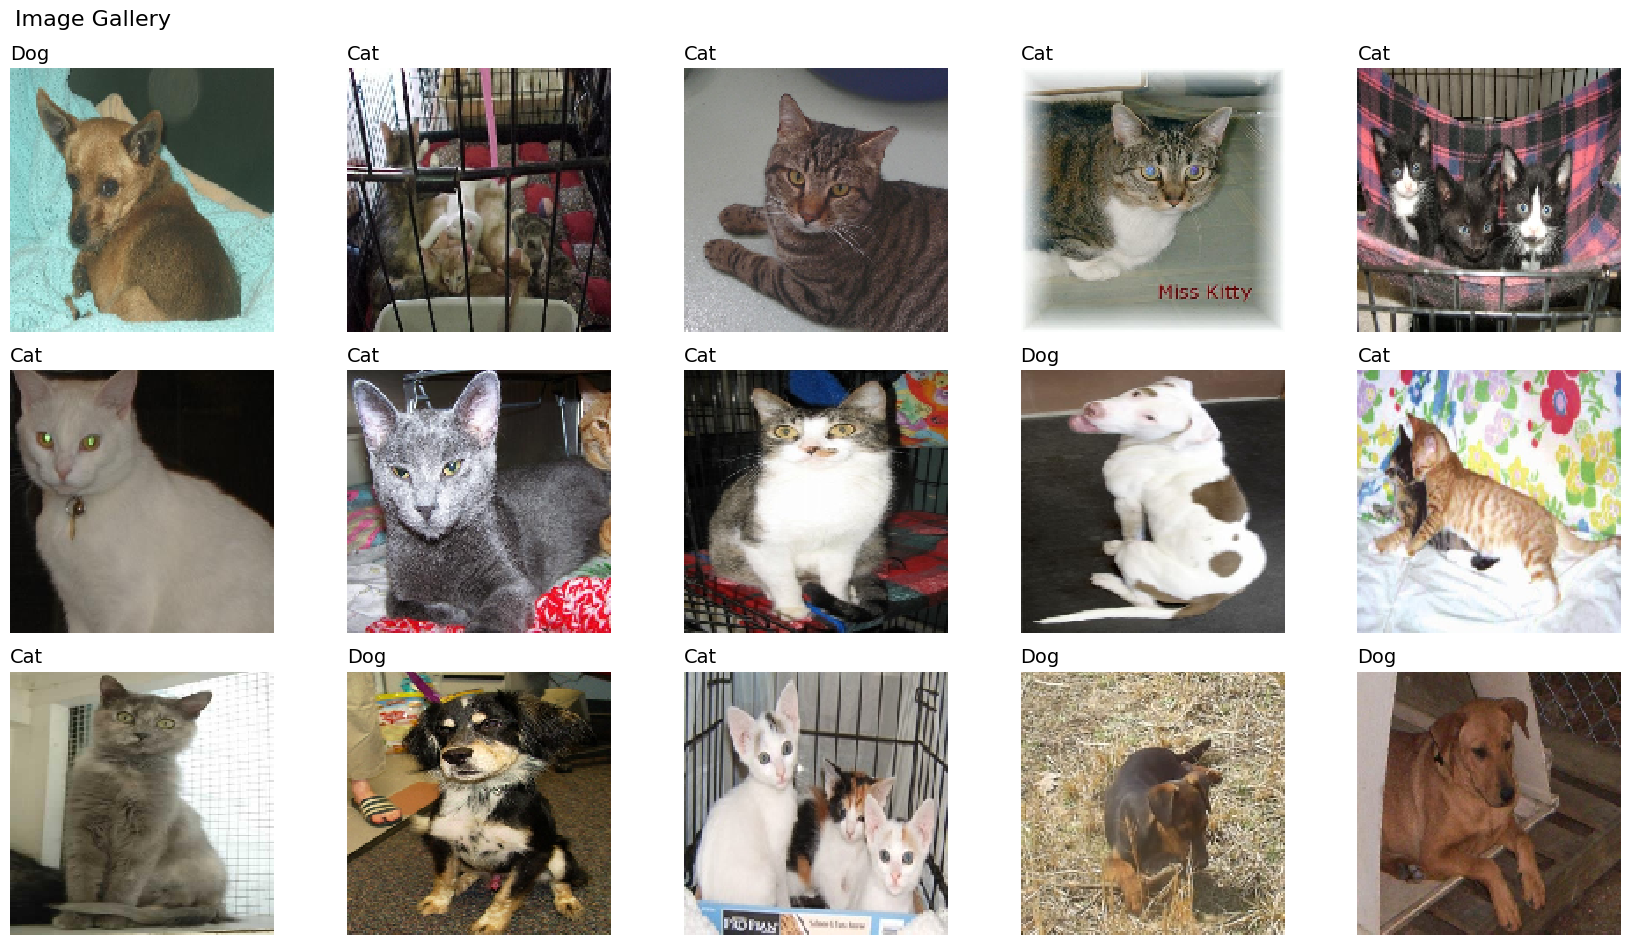

In [ ]:
# Plot gallery of images
plot_gallery(rgb_values, complete_y)

# Remove no more used variables to lighten resources usage
del(cats_dogs_df_part_1)
del(cats_dogs_df_part_2)
del(cats_dogs_df)

# Data Preparation
With 2,000 images (rows) and 67,500 features, transformations are required to use classic ML models, which expect that the number of features is smaller or equal than the number of rows. Thus, dimensionality reduction is required: images must be transformed to a lower-dimensional space, preserving key features for image classification.

The images are firstly recharacterized as a four-dimensional matrix and its are normalized the values in order to transform them into gray scale (67,500 features $\rightarrow$ 22,500 features). Afterwards, two different characterizations of the images are created:

1. **Principal Component Analysis (PCA)**: PCA searches for linear combinations of pixel values that maximize the explained variance. Its simplicity its one of its main assets, as it has a single hyperparmeter which must be adjusted beforehand: the number of Principal Components or, equivalently, the total explained variance. In particular, **1,357 features** (Principal Components -PCs-) are estimated in order to cover the 99% of the total variance.

2. **Histogram of Oriented Gradients (HOG)**: The HOG algorithm computes gradients across the image, groups them into cells and blocks, builds orientation histograms, normalizes them, and outputs a feature vector. This captures edge and shape information. In particular, the HOG set is composed of **1,536 features** given the chosen configuration which balances detail, computational efficiency and the characteristics of the images.

In [ ]:
# Transformation: (1) 4D structure, (2) Normalization, (3) Gray scale, (4) Back to 2D
rgb_values = np.array(rgb_values).reshape(rgb_values.shape[0],IMAGE_SIZE,IMAGE_SIZE,3)
rgb_values = rgb_values/255
gray_values_3d = color.rgb2gray(rgb_values)
gray_values = gray_values_3d.reshape(2000, -1)

# Values are turned into a dataframe to visualize more easily the data structure
pd.DataFrame(gray_values, columns=["Gr_"+str(width)+"_"+str(height) for width, height in
              itertools.product(range(IMAGE_SIZE), range(IMAGE_SIZE))]).head()

Gr_0_0    Gr_0_1    Gr_0_2    Gr_0_3    Gr_0_4    Gr_0_5    Gr_0_6  \
0  0.653866  0.673474  0.681317  0.689160  0.704846  0.713791  0.721634   
1  0.159408  0.161090  0.162221  0.156342  0.194992  0.142047  0.219913   
2  0.126942  0.061956  0.102020  0.164765  0.170369  0.184373  0.160844   
3  0.876184  0.876184  0.876184  0.872263  0.872263  0.880106  0.876757   
4  0.438932  0.442853  0.463868  0.487397  0.483773  0.312623  0.275922   

     Gr_0_7    Gr_0_8    Gr_0_9  ...  Gr_149_140  Gr_149_141  Gr_149_142  \
0  0.729477  0.737320  0.745163  ...    0.003639    0.003639    0.003639   
1  0.162496  0.125551  0.227511  ...    0.215261    0.215826    0.182496   
2  0.180452  0.203981  0.203981  ...    0.471987    0.503807    0.548285   
3  0.892443  0.880678  0.880678  ...    0.805894    0.801972    0.817658   
4  0.299452  0.389916  0.540893  ...    0.373248    0.386970    0.432057   

   Gr_149_143  Gr_149_144  Gr_149_145  Gr_149_146  Gr_149_147  Gr_149_148  \
0    0.003639    0.003639    0.003639    0.003639    0.003639    0.003639   
1    0.335438    0.262885    0.282493    0.209122    0.134612    0.196524   
2    0.586935    0.636212    0.672058    0.696414    0.708179    0.663389   
3    0.851286    0.866964    0.861071    0.847624    0.827719    0.832459   
4    0.474629    0.408527    0.334018    0.351668    0.363433    0.318912   

   Gr_149_149  
0    0.003639  
1    0.110249  
2    0.613264  
3    0.833858  
4    0.314990  

[5 rows x 22500 columns]

## Principal Component Analysis (PCA)
In this section, the PCA is conducted. As can be seen in the scree plot, the first ten PCs cover nearly 60% of the variance. In particular, the first one gathers more than 20%. The scatterplots demonstrates that the first 3 components are not discriminant of the classes by themselves. With the method `biplot`, the influence of the original variables could also be visualized although this lacks interest as they are just pixel values.

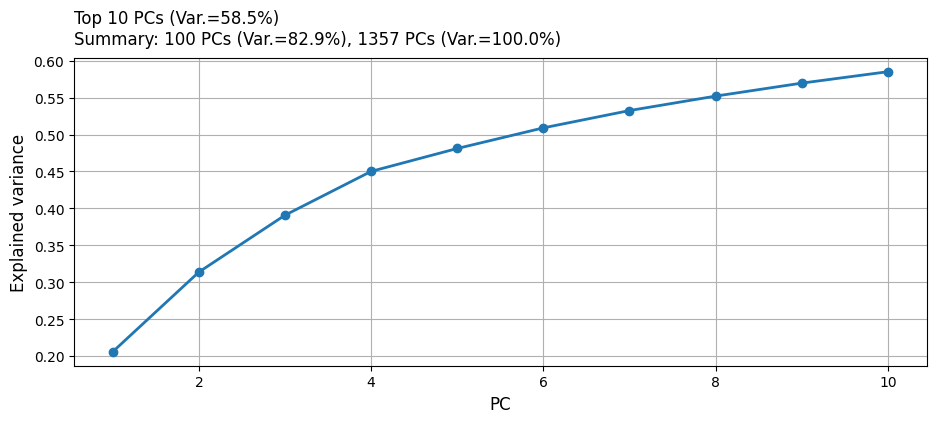

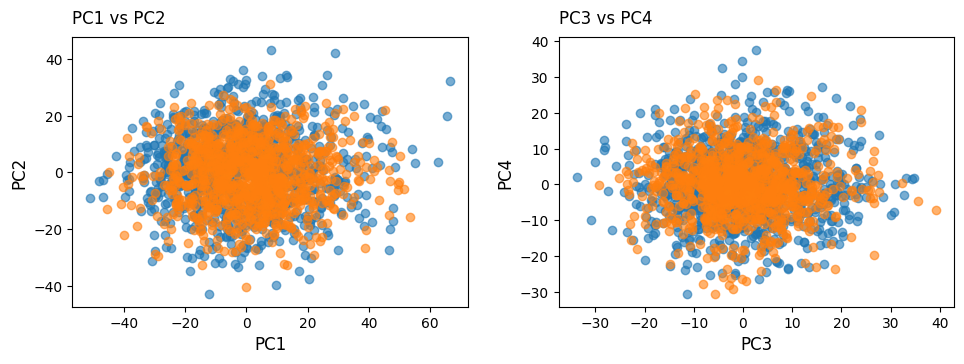

In [ ]:
# Return the number of PCs that cover at least 99% of variance
pca_model = pca(n_components=0.99)
cats_dogs_pca = pca_model.fit_transform(gray_values, verbose=0)

# Screeplot and scatter plots
plot_pca(pca_model=pca_model, fitted_pca=cats_dogs_pca, complete_y=complete_y)

# Extract the principal components' scores (and normalize them) and inverted scores (visualization)
pca_X = StandardScaler().fit_transform(cats_dogs_pca['PC'])
mu = gray_values.mean(axis=1).reshape(-1, 1)
pca_inv_scores_100 = np.dot(cats_dogs_pca['PC'].iloc[:,:100], cats_dogs_pca['loadings'].iloc[:100,:]) + mu
pca_inv_scores_all = np.dot(cats_dogs_pca['PC'], cats_dogs_pca['loadings']) + mu

# Remove no more used variables to lighten resources usage
del(pca_model)
del(cats_dogs_pca)

## Histogram of Oriented Gradients (HOG)

The next cell applies a HOG feature extraction process tailored for the image dataset. The configuration balances discriminative power and computational efficiency, given the high feature-to-sample ratio (67,500 features vs. 2,000 samples). In particular, the HOG parameters were set to yield 1,536 features, balancing discriminative edge information with computational constraints. The chosen parameters include:

- `orientations=6`: Captures gradient directions in six bins, reducing feature complexity while keeping edge data.
- `pixels_per_cell=(16, 16)`: Groups pixels into 16x16 cells, yielding approximately 81 cells per image (150/16 ≈ 9 cells per dimension), balancing spatial granularity and feature reduction.
- `cells_per_block=(2, 2)`: Normalizes gradients over 2x2 blocks, enhancing robustness to lighting variations.
- `block_norm='L2-Hys'`: Uses L2-norm with hysteresis to clip extreme values, improving stability.
- Others: `transform_sqrt=True` (reduces the impact of large gradient magnitudes), `feature_vector=True` (generates the feature vector) and `visualize=True` (produces a visual representation).

These settings were selected to mitigate the sample-to-feature ratio issue by producing a manageable number of features (1,536) compared to the original 67,500. Further optimization via grid search with a performance metric (e.g., accuracy) could enhance results but was omitted for simplicity.

In [ ]:
hog_output = [hog(img, orientations=6, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                  block_norm='L2-Hys', transform_sqrt=True, feature_vector=True, visualize=True)
              for img in gray_values_3d]

# Extract the HOG' scores (and normalize them) and inverted scores (visualization)
hog_X = StandardScaler().fit_transform([element[0] for element in hog_output])
hog_inv_scores =  np.stack([element[1] for element in hog_output])

# Remove no more used variables to lighten resources usage
del(hog_output)

The next cell shows how three images are characterized with 100 PCs, all the extracted PCs (1536) and the HOG features. In the case of PCA, the feature set should not be reduced as 100 PCs, even though they are able to explain more than 80% of the variability, increase notably the blurriness of the images. Moreover, HOG features clearly capture edge and shape information.

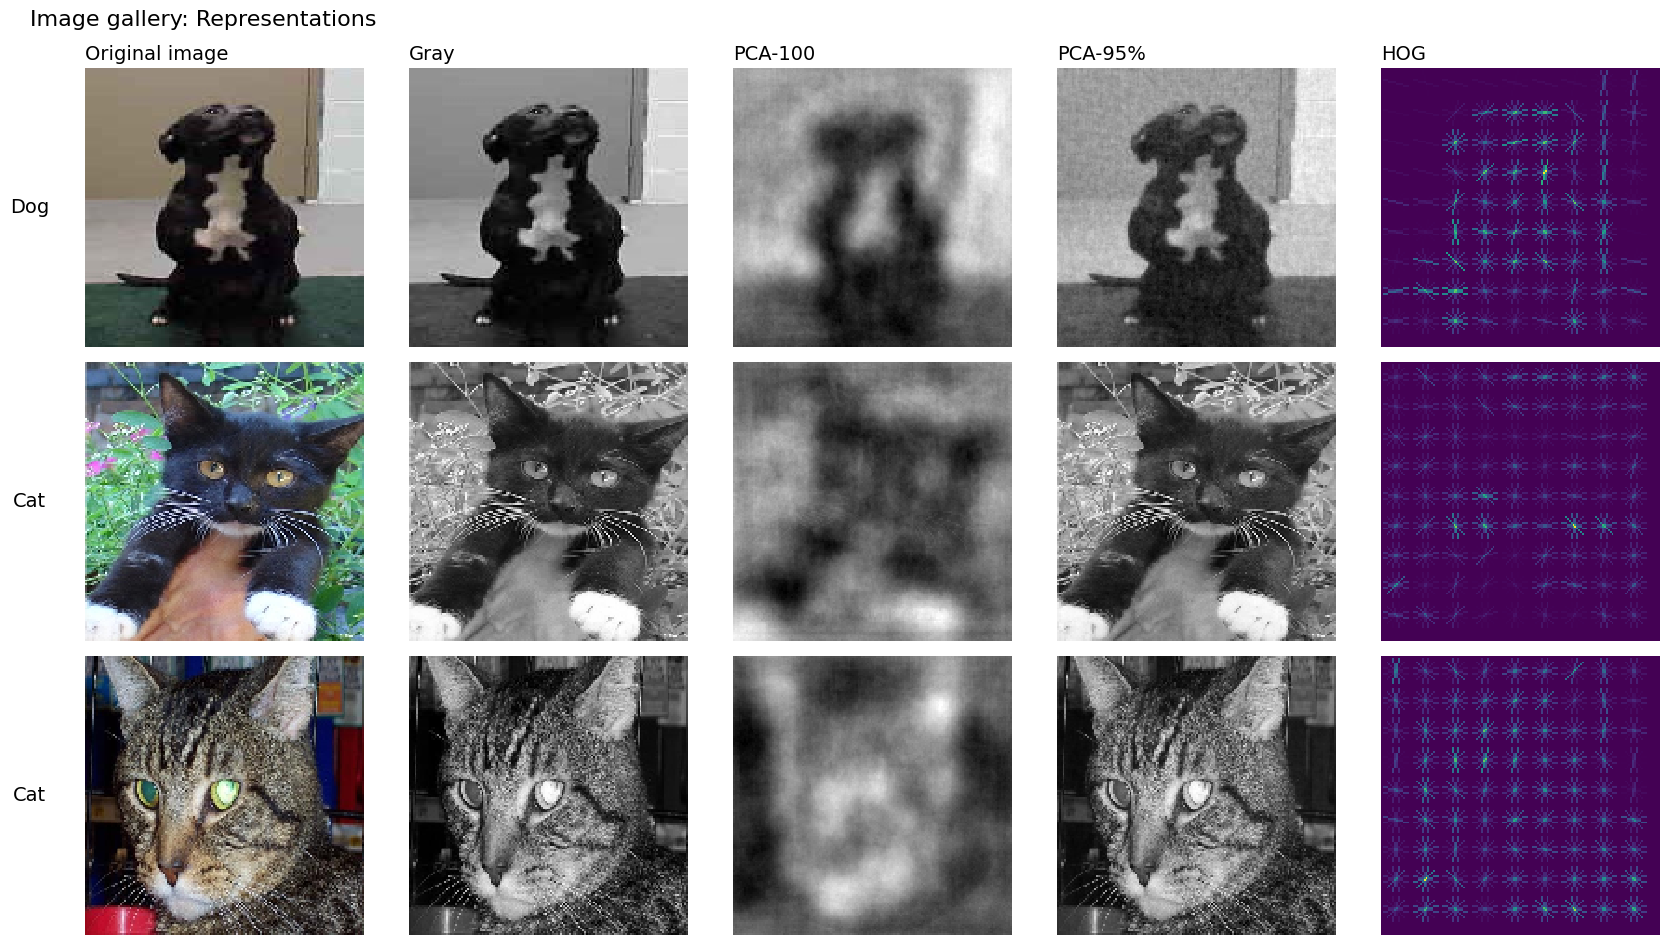

In [ ]:
np.random.seed(12)
random_subset = np.random.choice(range(rgb_values.shape[0]), 3, replace=False)

plot_gallery_representations(rgb_values=rgb_values, gray_values=gray_values, pca_inv_scores_100=pca_inv_scores_100,
                             pca_inv_scores_all=pca_inv_scores_all, hog_inv_scores=hog_inv_scores, y_values=complete_y,
                             selection = random_subset)

# Machine Learning models
This section contains the training and testing of different ML models in the task of distinguishing dog and cat images. In particular, the comparison includes **two different characterizations of the images** (PCA set: 1357 features, HOG set: 1536 features) and **three models** of increasingly complexity implemented within `scikit-learn`:

* Logistic regression, which assumes that the classes of the reponse variable are linearly separable with the features. Although it is enough for simple problems, in most of the cases it is used as benchmark.

* Decision Trees, in which the classification is performed by recursively splitting the data into regions based on feature values. Each split is determined by minimizing the variance within the resulting subsets, creating a tree-like structure where terminal nodes, or leaves, represent the predicted values. Its flexibility makes it able to capture non-linear patterns.

* Random Forest: ensemble method that builds multiple decision trees by recursively splitting data into regions based on feature values, with each split minimizing variance within subsets. Each tree is trained on a random subset of data and features, and predictions are aggregated (e.g., by majority vote or averaging) to improve robustness and accuracy. Its flexibility enables it to capture non-linear patterns while reducing overfitting.

The model will be fitted with the training set (85 % of the samples) and its performance will be evaluated with the independent test set. In particular,  **two measures** will be used for the comparisons:

* Accuracy: the proportion of correct predictions made by a model out of all predictions. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.
* F1 score: the harmonic mean of precision (proportion of positive predictions that are correct) and recall (proportion of actual positives correctly identified). In case where the classes are balanced, such as ours, it assures a balance between false positives and false negatives. Its value ranges from 0 to 1, which would mean that the model perfectly predicts the data.

In [ ]:
# Machine Learning: Classification functions
#def fit_and_evaluate_single_model(model, features_X, labels_y, kf):
def fit_and_evaluate_single_model(model, train_X, train_y, test_X, test_y):
    """
    Fit a single model using the training set and evaluate it in the test set, computing accuracy and F1-score.

    Parameters:
        model: Machine learning model (e.g., RandomForestClassifier).
        train_X: Feature matrix of the training set (e.g., HOG features or PCA-transformed data).
        train_y: Target labels of the training set (e.g., binary labels for cats vs. dogs).
        test_X: Feature matrix of the test set (e.g., HOG features or PCA-transformed data).
        test_y: Target labels of the test set (e.g., binary labels for cats vs. dogs).

    Returns:
        pd.DataFrame: DataFrame with the accuracy and F1-score of the model on the test set.
    """
    # Fit the model using the training set, check its performance on the test set.
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)

    # Return results as a DataFrame with a single row
    return pd.DataFrame({"Accuracy": [accuracy_score(test_y, y_pred)],
                         "F1 Score": [f1_score(test_y, y_pred)]})

def fit_and_evaluate_models(model_list, train_X_list, test_X_list, train_y, test_y):
    """
    Evaluate multiple models on multiple feature sets using the provided train-test split.

    Parameters:
        model_list: Dictionary of model names and their corresponding model objects.
        train_X_list: Dictionary of the training feature set names and their corresponding feature matrices.
        test_X_list: Dictionary of the test feature set names and their corresponding feature matrices.
        train_y: Target labels of the training set (e.g., binary labels for cats vs. dogs).
        test_y: Target labels of the test set (e.g., binary labels for cats vs. dogs).

    Returns:
        pd.DataFrame: Concatenated results with accuracy and F1-score metrics, indexed by model and feature set.
    """
    # Initialize an empty DataFrame to store results
    results = pd.DataFrame()

    for model_name, model in tqdm(model_list.items()):
        for features_name, features_X in train_X_list.items():
            # Evaluate the model on the current feature set
            acc_model = fit_and_evaluate_single_model(model, train_X=features_X, train_y=train_y,
                                                      test_X=test_X_list[features_name], test_y=test_y)

            # Add model and feature set names as columns. Append results to the main DataFrame
            acc_model["Model"] = model_name; acc_model["Features"] = features_name
            results = pd.concat([results, acc_model])

    results = results.set_index(['Model', 'Features'])
    return results

def plot_confusion_matrix(true_class, pred_class):
    """
    Plot two confusion matrices (absolute and normalized) side by side for binary classification.

    Parameters:
        true_class: Array of true class labels (e.g., test_y for cats vs. dogs).
        pred_class: Array of predicted class labels (e.g., test_pred_best from a model).

    Returns:
        None: Displays the plot with confusion matrices and accuracy.
    """
    # Set seaborn context for consistent font scaling (1.25x default)
    sns.set_context("notebook", font_scale=1.25)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Apply tight layout to adjust subplot spacing
    fig.tight_layout()

    # Define normalization options and titles (1. Absolute counts, 2. Row-normalized)
    normalize_options = [None, 'true']
    title_options = ['Absolute values', 'Normalized']
    titles_positions = [0.17, 0.15]

    # Iterate over the two subplots to create absolute and normalized confusion matrices
    for i in range(2):
        disp = ConfusionMatrixDisplay.from_predictions(y_true=true_class, y_pred=pred_class,
            display_labels=CLASS_NAMES, cmap=plt.cm.YlOrRd, normalize=normalize_options[i],  ax=axes[i])

        disp.ax_.set_xlabel('Pred. class')
        disp.ax_.set_ylabel('True class')
        disp.ax_.set_title(title_options[i], x=titles_positions[i])
        axes[i].tick_params(axis='both', which='major')

        # Remove individual colorbars to use a shared one later
        disp.im_.colorbar.remove()

    fig_suptitle = "Confusion matrices. Accuracy = {:.3f}".format(accuracy_score(true_class, pred_class))
    fig_suptitle += ". F1 Score = {:.3f}".format(f1_score(true_class, pred_class))
    fig.suptitle(fig_suptitle, y=1.08, x=0.38, fontsize='large')
    fig.colorbar(disp.im_, ax=axes)

def plot_ml_results(ml_results, data_is_long=True):
    """
    Plot machine learning model performance results as a bar plot.

    Parameters:
        ml_results (pd.DataFrame): DataFrame containing model performance metrics
        data_is_long (bool): Indicates if data is in long format (default: True)
    Returns:
        None: Displays the plot with ML results.

    """

    # Convert wide-format data to long format if necessary using melt
    if not data_is_long:
        ml_results = pd.melt(ml_results, id_vars=["Model", "Features"], var_name="Metric",
                           value_vars=["Accuracy", "F1 Score"], value_name="Value")

    # Create a combined column for y-axis labels with Model and Features
    ml_results['Model_Feature'] = ml_results['Model'] + "\n(" + ml_results['Features'] + ")"

    # Set seaborn style and custom colors. Create figure
    sns.set_style("whitegrid")
    custom_palette = {"Accuracy": "#33cc99", "F1 Score": "#f34235"}
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Create bar plot comparing model performance across metrics
    bar_plot = sns.barplot(data=ml_results, y='Value', x='Model_Feature', hue='Metric',
                           palette=custom_palette, alpha=1, ax=ax1)

    # Set axis limits, labels, ticks. Also title and legend
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("Performance Score", fontsize=12)
    ax1.set_xlabel("")
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)

    ax1.set_title("Model Performance by Feature Set and Metric", fontsize=14,
                 loc='left', weight='bold', pad= 20)
    ax1.legend(title="Metric", title_fontsize='12', fontsize='10',
               loc='upper right', frameon=True)

    # Add value labels to each bar
    for p in bar_plot.patches:
      height = p.get_height()  # Use height instead of width for vertical bars
      if height > 0:
        ax1.text(p.get_x() + p.get_width() / 2, height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

The next cell divides the data into training and test sets, fits the ML models and check their performance in the test set.

In [ ]:
total_n = hog_X.shape[0]
test_n = int(0.15*total_n); train_n = int(0.85*total_n)

# Randomly decide the datasets for training, validation and testing
pca_train_X, pca_test_X, train_y, test_y = train_test_split(pca_X, complete_y, test_size=test_n, random_state=1)
hog_train_X, hog_test_X, train_y, test_y = train_test_split(hog_X, complete_y, test_size=test_n, random_state=1)

print("DATASET : Train: "+str(train_n)+", Test: "+str(test_n)+"\n")

# Fit and evaluate the models within model_list
model_list = {"Logistic Regression": LogisticRegression(penalty = None),
              "Decision Tree": DecisionTreeClassifier(random_state=123),
              "Random Forest": RandomForestClassifier(random_state=123)}

ml_results = fit_and_evaluate_models(model_list = model_list, train_y = train_y, test_y = test_y,
                        train_X_list = {"PCA": pca_train_X, "HOG": hog_train_X},
                        test_X_list = {"PCA": pca_test_X, "HOG": hog_test_X})
ml_results

DATASET : Train: 1700, Test: 300



100%|██████████| 3/3 [00:26<00:00,  8.69s/it]


Accuracy  F1 Score
Model               Features                    
Logistic Regression PCA       0.470000  0.449827
                    HOG       0.646667  0.670807
Decision Tree       PCA       0.500000  0.503311
                    HOG       0.613333  0.639752
Random Forest       PCA       0.566667  0.585987
                    HOG       0.666667  0.659864

Explained variance does not equal discrimination power: the PCA features are clearly inferior to the HOG features, as all the models attain better results with the former set.

In terms of models, the logistic model indicates that the classes are, somewhat, linearly separable. The decision trees completely underperform for their complexity, probably due to overfitting. Their ensemble in the form of Random Forest, along with techniques such as random feature selection and pruning, improve the results.

## Hyperparameter tuning of the Random Forest model

The result of the HOG-based Random Forest model can be improved with **hyperparameter tuning**. The training set will also serve as validation set: it will be used to search for the best hyperparameter combination using cross validation, and the test set, an independent dataset used to measure the performance of the model in unseen data. In particular, **5-fold cross validation** will be used (dataset is divided into 5 equal parts, using 4 for training and 1 for testing in each of 10 iterations, averaging the results to evaluate model performance) and, instead of an exhaustive search in a smaller hyperparameter space, the tuning will consist of 30 random combinations in broader space using `RandomizedSearchCV`.

The grid search for the tuning will include these hyperparameter:

* `n_estimators`: The number of decision trees in the forest. Higher values generally improve performance by reducing variance but increase computational cost.
* `min_samples_split`: The minimum number of samples required to split an internal node. Higher values prevent overfitting by ensuring larger subsets before splitting.
* `min_samples_leaf`: The minimum number of samples required at a leaf node. Higher values promote smoother models by avoiding small, noisy leaves.
* `max_features`: The number of features considered for the best split at each node. Lower values increase randomness, reducing overfitting while maintaining diversity among trees. The value `sqrt` is the square root of the total number of features.



In [ ]:
# Hyperparameter optimization of the random forest model
hyperparam_grid = {
    'n_estimators': [100, 150, 200, 250],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [0.1, 0.2, 0.3, 'sqrt'],
    'max_depth': [10, 20, 30, None],
    # 'class_weight': [None, 'balanced']  # Unneeded as classes are balanced
}

# Grid search (n_jobs=-1 -> make use of all available processors)
grid_search = RandomizedSearchCV(RandomForestClassifier(random_state=123),
                                 hyperparam_grid, n_iter=30, random_state=123,
                                 cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(hog_train_X, train_y)
print(f"Best CV accuracy: {grid_search.best_score_:.3f} with hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.722 with hyperparameters: {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.1, 'max_depth': 20}


The Random Forest model achieves optimal performance by training a larger number of simpler decision trees, as evidenced by increasing `n_estimators` and decreasing `max_features`.

The optimized model is evaluated in the following cell, correctly classifying approximately 70% of the images, with errors distributed evenly across both classes.

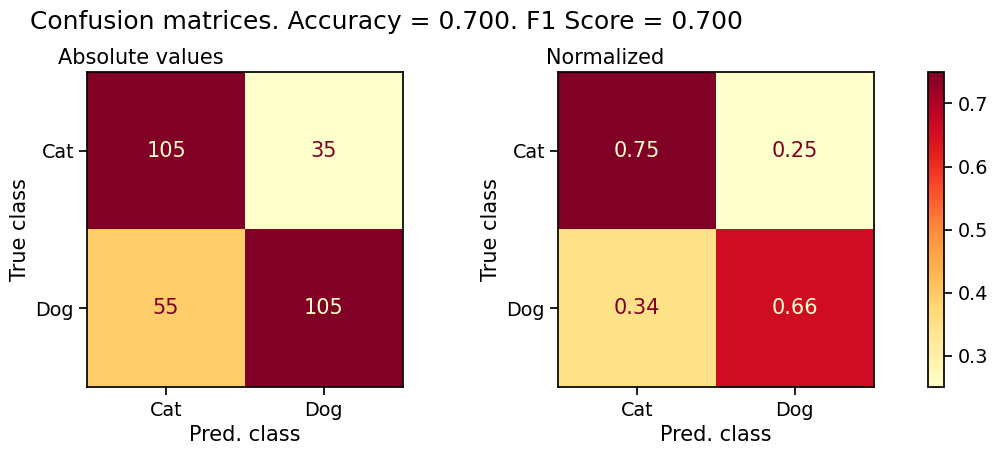

In [ ]:
# Evaluate best model in the Test dataset
best_rf = grid_search.best_estimator_
test_pred_best = best_rf.predict(hog_test_X)
plot_confusion_matrix(test_y, test_pred_best)

# Save results in summary results dataframe
ml_results = ml_results.reset_index()
rf_hog_cond = (ml_results["Model"] == "Random Forest") & (ml_results["Features"] == "HOG")
ml_results.loc[rf_hog_cond, "Accuracy"] = 0.700
ml_results.loc[rf_hog_cond, "F1 Score"] = 0.700

Examining misclassified images in the test set reveals patterns for two different groups of cases: noisy images (containing blurry sections, additional objects, or multiple animals) and seemingly normal images. The final notebook cell illustrates these distinctions, showing that HOG features fail to effectively capture the animals' shapes and edges. Moreover, the dataset contains at least one erroneous image (that does not contain either a cat or dog), suggesting the need for further dataset cleaning.

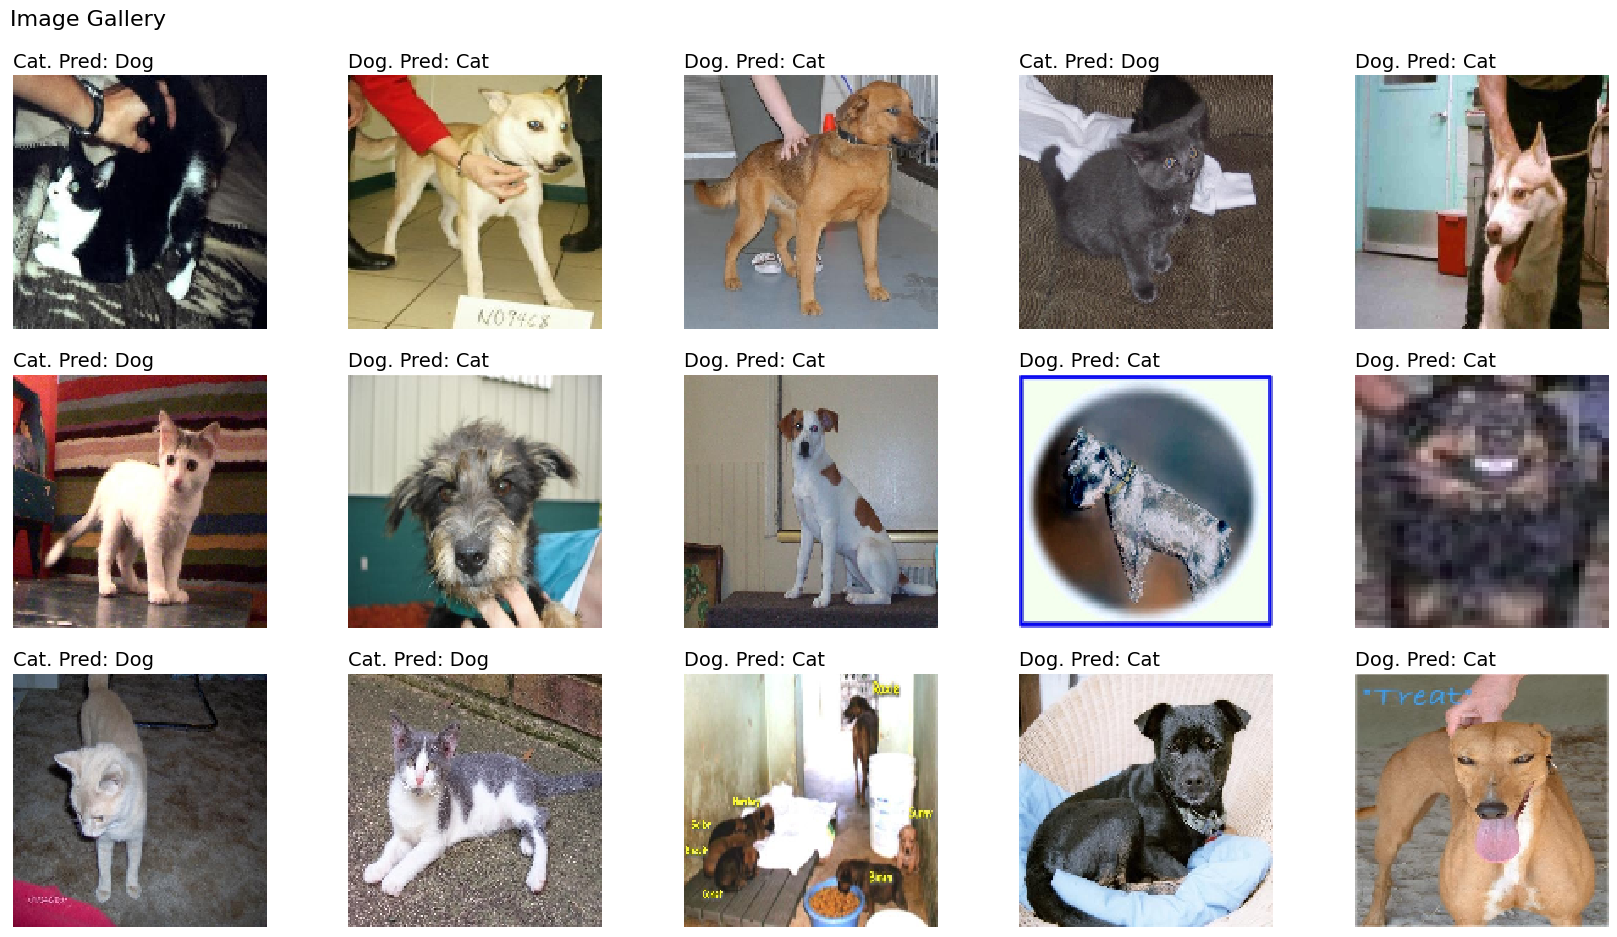

In [ ]:
# See some examples of wrong predictions
np.random.seed(21)
random_subset_wrong = np.random.choice((np.where(test_pred_best!=test_y)[0]).tolist(), 15, replace=False)
plot_gallery(X_values = rgb_values[list(test_y.index),], y_values = list(test_y),
               y_labels = test_pred_best, selection = random_subset_wrong)

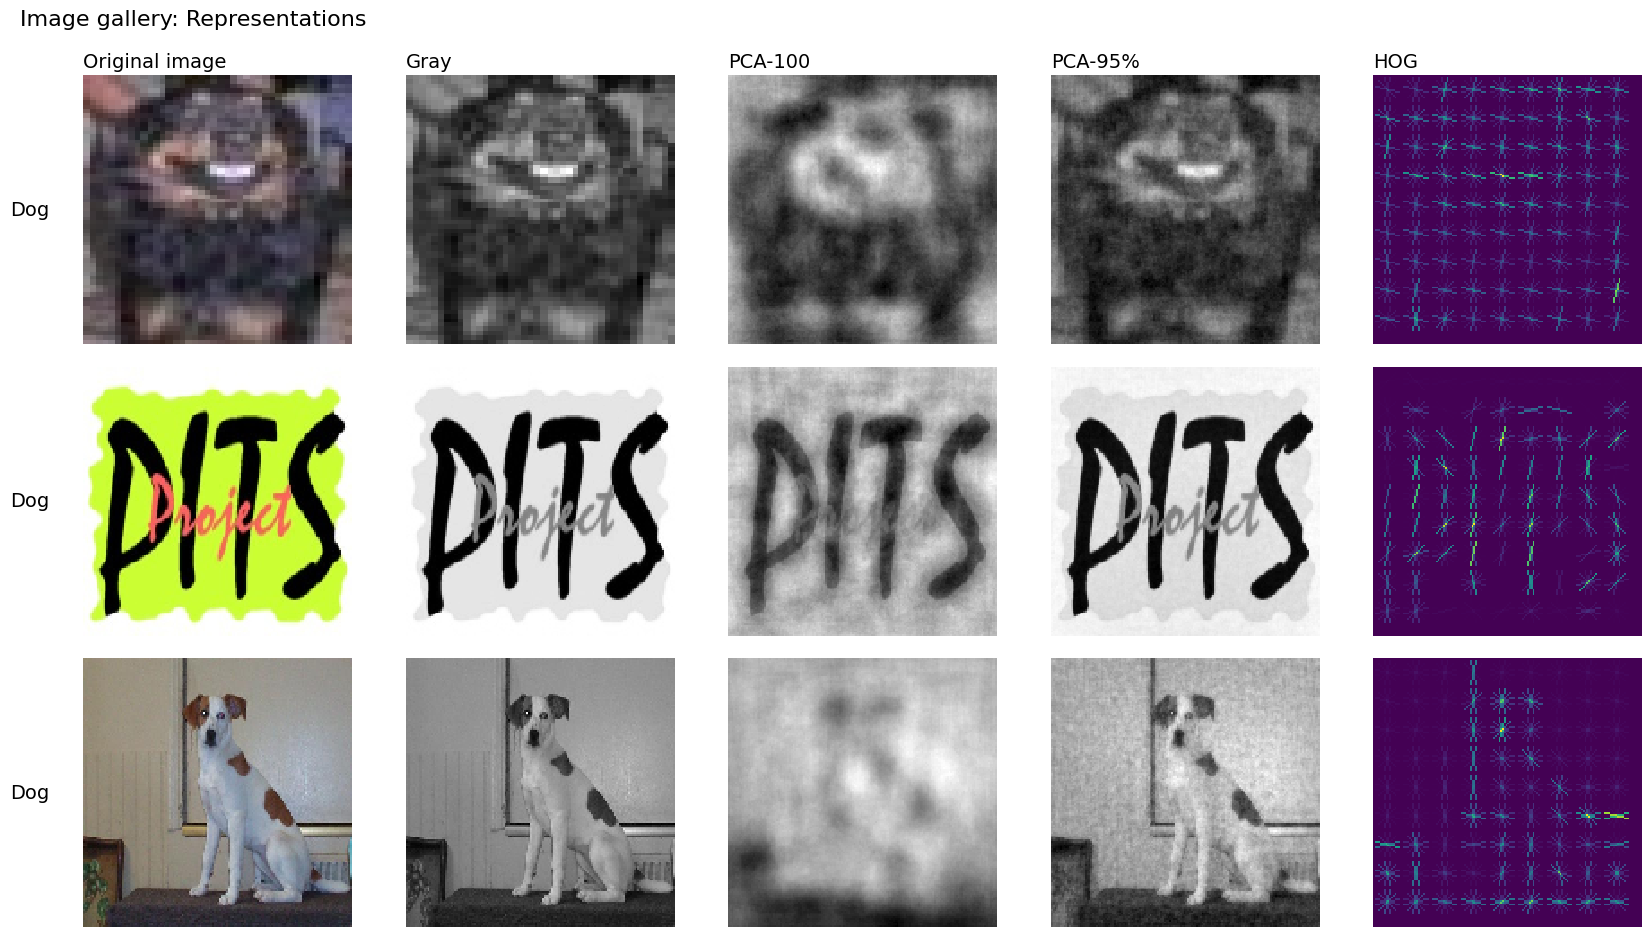

In [ ]:
# Selection of images wrongly classified due to not being correctly charactized by HOG
mistake_examples = test_y.iloc[random_subset_wrong].index[[6,9]].values

# Moreover, there are examples of images without dogs or cats
wrong_examples = np.append(mistake_examples, 1265)

# Representation of the images
plot_gallery_representations(
    rgb_values=rgb_values[wrong_examples], gray_values=gray_values[wrong_examples],
    hog_inv_scores=hog_inv_scores[wrong_examples], pca_inv_scores_100=pca_inv_scores_100[wrong_examples],
    pca_inv_scores_all=pca_inv_scores_all[wrong_examples], y_values=complete_y[wrong_examples].tolist())

# Discussion and conclusion

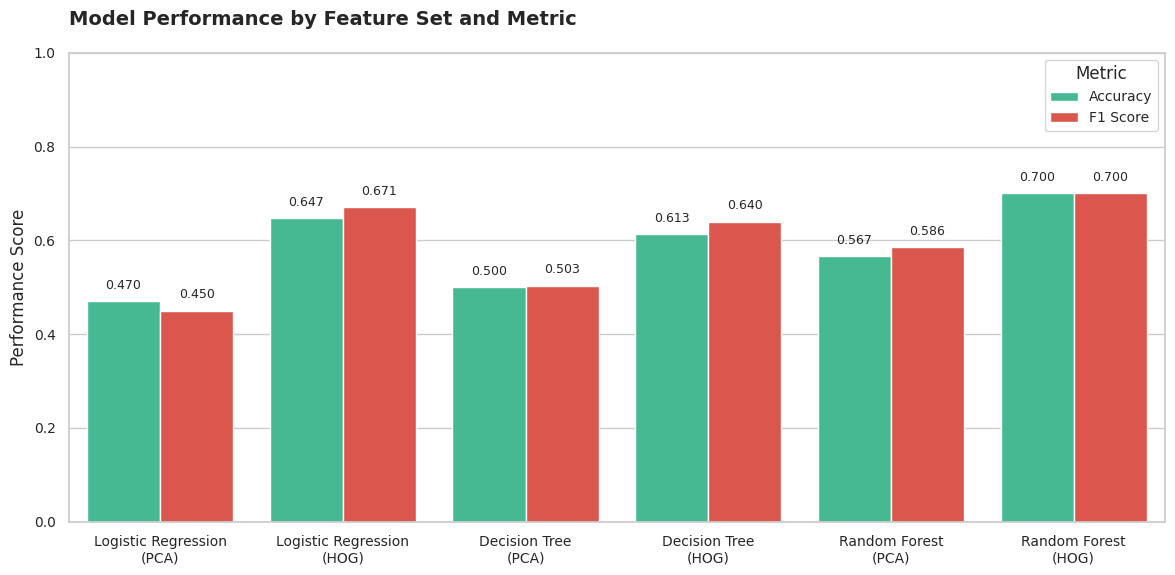

In [ ]:
plot_ml_results(ml_results, data_is_long=False)

This notebook developed machine learning models to classify images of cats and dogs using a preprocessed dataset of 2,000 images, each resized to 150x150 pixels with three color channels, resulting in 67,500 initial features. Two feature sets were derived: Principal Component Analysis (PCA) with 1,357 components (capturing more than 99% variance) and Histogram of Oriented Gradients (HOG) with 1,536 features. Three models —Logistic Regression, Decision Tree, and Random Forest— were evaluated using an indepedent test dataset to distinguish between cats and dogs. The analysis addressed high-dimensionality challenges and included hyperparameter tuning and misclassification analysis to understand model limitations.

## Key Findings
1. **Model Performance**: The Random Forest model with HOG features achieved the best performance (0.700 test accuracy), balancing accuracy and generalization, while Logistic Regression and Decision Tree models underperformed due to limited complexity and overfitting, respectively.
2. **Feature Importance**: HOG features were superior to PCA, highlighting the importance of edge and shape information for cat-dog classification. PCA, despite capturing full variance, was less discriminative due to image blurriness.
3. **Hyperparameter tuning**: `RandomizedSearchCV` enabled efficient exploration of a broader hyperparameter space for the Random Forest model, slightly improving cross-validation accuracy compared to an exhaustive grid search approach.
4. **Misclassification Patterns**: Errors stemmed from noisy images (blurry, cluttered) and limitations in HOG feature extraction, with one erroneous image indicating dataset quality issues.
5. **Dataset Limitations**: The high feature-to-sample ratio (67,500 features from 150x150x3 pixels, 2,000 samples) and potential noise/mislabeling suggest preprocessing improvements are critical for better performance.

## Future Work and Applications
- To enhance feature engineering and address the limitations of classical machine learning models, which achieved a maximum test accuracy of 0.700 using HOG features with Random Forest but struggled with noisy images and complex patterns, the next notebook will transition to **Convolutional Neural Networks (CNNs)**. Unlike HOG and PCA, which rely on "handcrafted" features and introduce challenges like blurriness or insensitivity to subtle shapes, CNNs can automatically learn hierarchical feature representations directly from raw images, potentially improving accuracy and robustness. This shift is expected to better capture spatial relationships and local patterns, addressing misclassification issues observed in blurry or cluttered images. The forthcoming notebook will explore CNN architectures and transfer learning with pre-trained models to enhance performance and generalizability for cat-dog classification tasks.
- **Dataset Preprocessing and Expansion**: Enhance dataset cleaning to remove erroneous or noisy images (e.g., blurry, multi-object) and include more diverse images (e.g., different breeds, lighting conditions, backgrounds) to improve generalizability to real-world scenarios.
- **Applications**: With improved accuracy via CNNs and transfer learning, the model could support automated pet identification in shelters, content moderation on social platforms, or educational tools for animal recognition, offering practical value in real-world settings.

This notebook demonstrates proficiency in tackling high-dimensional image classification using classical machine learning techniques. By comparing feature sets, optimizing models, and analyzing misclassifications, it lays a foundation for subsequent notebooks that will leverage CNNs and transfer learning to achieve higher accuracy and robustness in cat-dog classification tasks.